In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from sklearn.metrics import confusion_matrix

In [3]:
PATH = "data/chest_xray/"

In [4]:
normal_example = os.listdir(f'{PATH}train/NORMAL')[0]
pneumonia_example = os.listdir(f'{PATH}train/PNEUMONIA')[0]

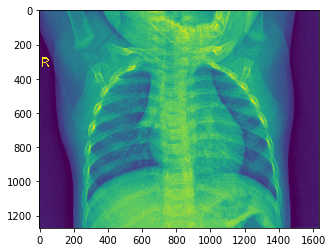

In [5]:
normal_img = plt.imread(f'{PATH}train/NORMAL/{normal_example}')
plt.imshow(normal_img)

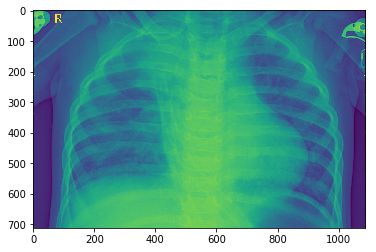

In [6]:
pneumonia_img = plt.imread(f'{PATH}train/PNEUMONIA/{pneumonia_example}')
plt.imshow(pneumonia_img)

In [7]:
# cnn architecture
arch = resnet34

In [8]:
def get_data(sz, bs):
    # data augmentation
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=2)
    data = ImageClassifierData.from_paths(PATH, bs=bs, tfms=tfms, val_name='val',
                                          test_name="test", test_with_labels=True)
    return data

In [9]:
data = get_data(64, 64)
learn = ConvLearner.pretrained(arch, data, ps=0.8, precompute=False)

In [10]:
print("train size: {}".format(data.trn_ds.n))
print("validation size: {}".format(data.val_ds.n))
print("test size: {}".format(data.test_ds.n))

train size: 5216
validation size: 16
test size: 624


 87%|████████▋ | 71/82 [00:24<00:03,  2.86it/s, loss=4.63] 

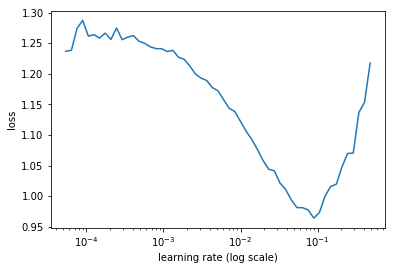

In [11]:
lrf = learn.lr_find()
learn.sched.plot()

In [12]:
learn.fit(1e-2, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.577421   0.378927   0.75      
    1      0.49291    0.417549   0.6875                    


[array([0.41755]), 0.6875]

In [13]:
learn.unfreeze()
lrs = np.array([1e-4, 1e-3, 1e-2])
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.492564   0.260924   0.875     
    1      0.410613   0.322319   0.875                     
    2      0.319297   0.516492   0.6875                    


[array([0.51649]), 0.6875]

In [14]:
data = get_data(128, 64)
learn.set_data(data)
learn.freeze()
learn.fit(1e-2, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.491013   0.653883   0.5       
    1      0.465389   0.655673   0.5                       


[array([0.65567]), 0.5]

In [15]:
learn.unfreeze()
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.317376   0.790183   0.625     
    1      0.26542    0.737937   0.75                      
    2      0.250588   0.687114   0.75                      


[array([0.68711]), 0.75]

In [16]:
data = get_data(256, 64)
learn.set_data(data)
learn.freeze()
learn.fit(1e-2, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.339632   0.770486   0.5       
    1      0.338026   0.72867    0.5                       


[array([0.72867]), 0.5]

In [17]:
learn.unfreeze()
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.273996   0.905763   0.625     
    1      0.239708   1.137225   0.625                     
    2      0.203927   0.907976   0.6875                    


[array([0.90798]), 0.6875]

In [18]:
# test time augmentation
log_probs, y = learn.TTA(is_test=True)

In [19]:
log_probs.shape

(5, 624, 2)

In [20]:
probs = np.mean(np.exp(log_probs), axis=0)

In [21]:
probs.shape

(624, 2)

In [22]:
# baseline
print("Baseline accuracy: {}".format(y.mean()))

Baseline accuracy: 0.625


In [23]:
test_accuracy = accuracy_np(probs, y)
print("test set accuracy: {}".format(test_accuracy))

test set accuracy: 0.9086538461538461


[[180  54]
 [  3 387]]


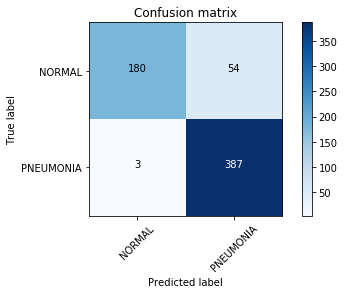

In [24]:
preds = np.argmax(probs, axis=1)
cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, data.classes)